# A predictive approach to estimate the maximum voluntary activation of the shoulder muscles

Romain Martinez<sup>*a</sup>, Jonathan Tremblay<sup>a</sup>, Mickael Begon<sup>a</sup>, Fabien Dal Maso<sup>a</sup>

<sup>a</sup>École de kinésiologie et des sciences de l’activité physique, Faculté de Medecine, Université de Montréal, Montréal, Canada

[GitHub repo](https://github.com/romainmartinez/mvc)

# Part 1: Getting the data

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.io as sio

# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
PROJECT_PATH = Path("./")
DATA_PATH = PROJECT_PATH / "data"
MODEL_PATH = PROJECT_PATH / "model"

## Read the data

We start this notebook with data in matlab format, where each file corresponds to different experiments.

Each file contains a 3-dimensional matrix where the first dimension corresponds to the _participant_, the second to the _tested muscle_ and the third to the _test performed_.

![Maximum voluntary isometric contraction tests performed.](./share/fig/positions.svg)

In [3]:
mat = {}
data = {key: [] for key in ("dataset", "participant", "muscle", "test", "mvc")}
dataset_names = []
count = -1


for ifile in DATA_PATH.glob("*only_max.mat"):
    # dataset name
    dataset = ifile.stem.replace("_only_max", "").replace("MVE_Data_", "")
    dataset_names.append(dataset)

    # data
    mat[dataset] = sio.loadmat(ifile)["MVE"]
    print(f"project {dataset}: {mat[dataset].shape[0]} participants")

    for iparticipant in range(mat[dataset].shape[0]):
        count += 1
        for imuscle in range(mat[dataset].shape[1]):
            for itest in range(mat[dataset].shape[2]):
                data["participant"].append(count)
                data["dataset"].append(dataset)
                data["muscle"].append(imuscle)
                data["test"].append(itest)
                data["mvc"].append(mat[dataset][iparticipant, imuscle, itest])

project Romain2017: 32 participants
project Landry2015_1: 14 participants
project Landry2012: 18 participants
project Yoann_2015: 22 participants
project Tennis: 16 participants
project Violon: 10 participants
project Patrick_2013: 16 participants
project Landry2015_2: 11 participants
project Landry2016: 15 participants
project Sylvain_2015: 10 participants
project Landry2013: 21 participants


## Transform the data

In [4]:
df_tidy = pd.DataFrame(data).dropna()
df_tidy["test"] = df_tidy["test"].apply(lambda x: f"test {str(x + 1).zfill(2)}")

MUSCLES = [
    "upper trapezius",
    "middle trapezius",
    "lower trapezius",
    "anterior deltoid",
    "middle deltoid",
    "posterior deltoid",
    "pectoralis major",
    "serratus anterior",
    "latissimus dorsi",
    "supraspinatus",
    "infraspinatus",
    "subscapularis",
]


df_tidy["muscle"] = np.array(MUSCLES)[df_tidy["muscle"]]

print(f"dataset shape = {df_tidy.shape}")
df_tidy.head()

dataset shape = (18465, 5)


,dataset,participant,muscle,test,mvc
0,Romain2017,0,upper trapezius,test 01,0.000381
3,Romain2017,0,upper trapezius,test 04,0.000300
4,Romain2017,0,upper trapezius,test 05,0.000348
5,Romain2017,0,upper trapezius,test 06,0.000111
8,Romain2017,0,upper trapezius,test 09,0.000249


In [5]:
df_wide = df_tidy.pivot_table(
    index=["dataset", "participant", "muscle"],
    columns="test",
    values="mvc",
    fill_value=np.nan,
).reset_index()
df_wide.head()

test,dataset,participant,muscle,test 01,test 02,test 03,test 04,test 05,test 06,test 07,test 08,test 09,test 10,test 11,test 12,test 13,test 14,test 15,test 16
0,Landry2012,46,anterior deltoid,0.013480,0.060322,0.102243,0.262121,0.216671,0.007603,0.009864,0.030523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Landry2012,46,latissimus dorsi,0.003968,0.077672,0.019619,0.024144,0.021569,0.151734,0.145337,0.060694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Landry2012,46,lower trapezius,0.025092,0.205321,0.300761,0.170296,0.191271,0.070199,0.140505,0.017468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Landry2012,46,middle deltoid,0.028731,0.145174,0.170468,0.085861,0.121181,0.035754,0.009872,0.011396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Landry2012,46,middle trapezius,0.011083,0.135626,0.130890,0.042650,0.062615,0.046499,0.040964,0.016394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Part 2: Data exploration

In [6]:
import altair as alt
from altair import datum
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Muscles and tests count

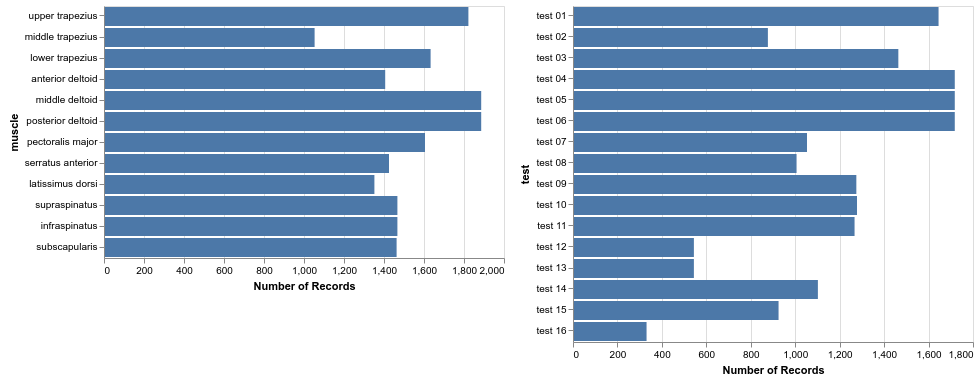

In [7]:
base = alt.Chart(df_tidy).encode(x="count()")
muscle = base.mark_bar().encode(alt.Y("muscle", sort=alt.Sort(MUSCLES)))
test = base.mark_bar().encode(y="test")
muscle | test

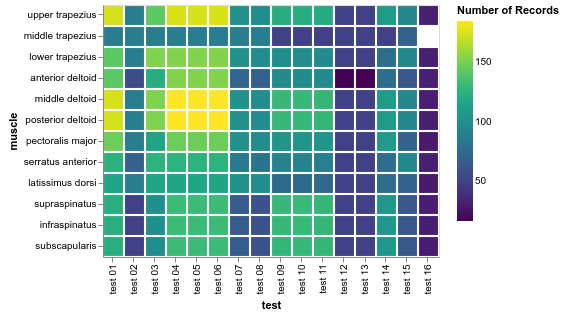

In [8]:
alt.Chart(df_tidy).mark_rect().encode(
    x="test", y=alt.Y("muscle", sort=alt.Sort(MUSCLES)), color="count()"
)

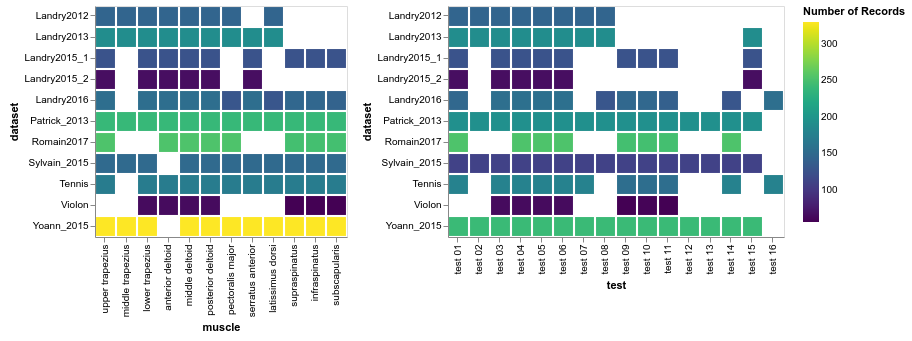

In [9]:
base = alt.Chart(df_tidy).encode(y="dataset", color="count()")
test = base.mark_rect().encode(x="test")
muscle = base.mark_rect().encode(alt.X("muscle", sort=alt.Sort(MUSCLES)))
muscle | test

## NaNs count

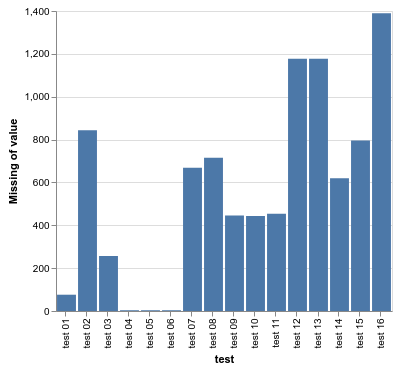

In [10]:
alt.Chart(df_wide.melt(id_vars=["dataset", "participant", "muscle"])).mark_bar().encode(
    x="test", y="missing(value)"
)

## Which test normalizes which muscle

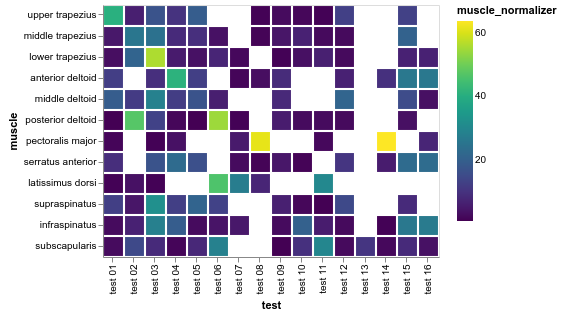

In [11]:
dff = df_tidy.groupby(["test", "muscle"])["mvc"].count().rename("count").to_frame()

max_test = (
    df_tidy.groupby(["participant", "muscle"], as_index=False)
    .apply(lambda x: x["test"][x["mvc"].idxmax()])
    .rename("test")
    .reset_index()
)

dff = dff.merge(
    max_test.groupby(["muscle", "test"]).count().reset_index(), on=["muscle", "test"]
).rename(columns={"participant": "max_test"})


dff["muscle_normalizer"] = dff["max_test"] / dff["count"] * 100

alt.Chart(dff).mark_rect().encode(
    x="test", y=alt.Y("muscle", sort=alt.Sort(MUSCLES)), color="muscle_normalizer"
)

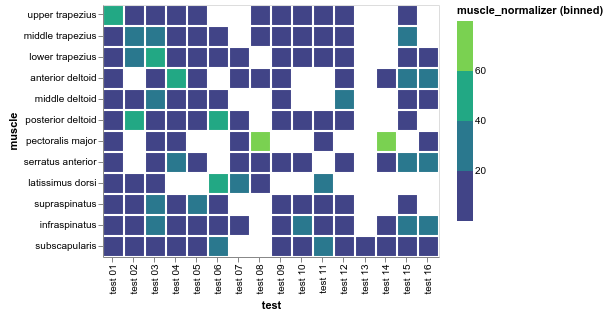

In [12]:
alt.Chart(dff).mark_rect().encode(
    x="test",
    y=alt.Y("muscle", sort=alt.Sort(MUSCLES)),
    color=alt.Color("muscle_normalizer", bin=True),
)

# Part 3: Machine learning pipeline

Since tests number 4, 5 and 6 have few missing data (3) and are good normalizers, we will try to predict the maximum obtained with the 16 tests from these three tests alone.

## Split the data

In [13]:
from sklearn.model_selection import GroupShuffleSplit


class Pipeline:
    def __init__(self):
        pass

    def get_X_and_y(self, d, cols):
        d = self.drop_na_rows(d, cols)
        X = d[cols].drop("muscle", axis=1)
        y = d.select_dtypes(include="float64").max(axis=1)
        p = d["participant"]
        return X, y, p

    @staticmethod
    def drop_na_rows(d, cols):
        c = [i for i in cols if i != "muscle"]
        return d.dropna(how="all", subset=c)

    @staticmethod
    def split_data(X, y, p, test_size):
        # we want to make sure that all the data from one participant is in only one set
        train_id, test_id = next(
            GroupShuffleSplit(test_size=test_size, random_state=RANDOM_SEED).split(
                X, groups=p
            )
        )
        return X.iloc[train_id], X.iloc[test_id], y.iloc[train_id], y.iloc[test_id]

## Normalization

In [14]:
class Normalize:
    def __init__(self, ref):
        self.ref = ref

    def fit(self, X, y=None):
        self.ref_vector = X[self.ref]
        return self

    def transform(self, X):
        return X.multiply(100, axis=0).divide(self.ref_vector, axis=0)

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

    def inverse_transform(self, X):
        return X.divide(100, axis=0).multiply(self.ref_vector, axis=0)

## Evaluation

In [15]:
from sklearn.metrics import r2_score


class Evaluate:
    def __init__(self):
        pass

    @staticmethod
    def mape(y_true, y_pred):
        val = (np.abs((y_true - y_pred) / y_true)) * 100
        return val.mean()

    @staticmethod
    def rmse(y_true, y_pred):
        val = np.sqrt(((y_pred - y_true) ** 2).mean())
        return val

    def report(self, y_true, y_pred):
        d = {
            "rmse": self.rmse(y_true, y_pred),
            "mape": self.mape(y_true, y_pred),
            "r2": r2_score(y_true, y_pred),
        }
        return d

In [16]:
from xgboost import XGBRegressor

COLS_TO_KEEP = ["muscle", "test 04", "test 05", "test 06"]
TEST_SIZE = 0.2
base_params = {"n_jobs": 1, "silent": True, "random_state": RANDOM_SEED}
results = {"train": {}, "test": {}}

for imuscle in MUSCLES:
    subset = df_wide[df_wide["muscle"] == imuscle]
    pipe = Pipeline()
    X, y, participants = pipe.get_X_and_y(d=subset, cols=COLS_TO_KEEP)
    X_train, X_test, y_train, y_test = pipe.split_data(
        X, y, participants, test_size=0.2
    )

    norm_train = Normalize(ref="test 05").fit(X_train)
    X_train, y_train = (norm_train.transform(X_train), norm_train.transform(y_train))

    norm_test = Normalize(ref="test 05").fit(X_test)
    X_test, y_test = norm_test.transform(X_test), norm_test.transform(y_test)

    fit_params = {
        "eval_set": [(X_train, y_train), (X_test, y_test)],
        "early_stopping_rounds": 50,
        "eval_metric": "rmse",
        "verbose": None,
    }

    model = XGBRegressor(**base_params)
    model.fit(X_train, y_train, **fit_params)
    results["train"][imuscle] = Evaluate().report(y_train, model.predict(X_train))
    results["test"][imuscle] = Evaluate().report(y_test, model.predict(X_test))

In [24]:
r = pd.DataFrame()
for isplit in ["train", "test"]:
    s = pd.DataFrame(results[isplit]).T.rename_axis("muscle").reset_index()
    s["split"] = isplit
    r = pd.concat([r, s])
print(f"mean for all muscles:\n{r.mean()}")

mean for all muscles:
mape     28.008721
r2        0.505313
rmse    972.777071
dtype: float64


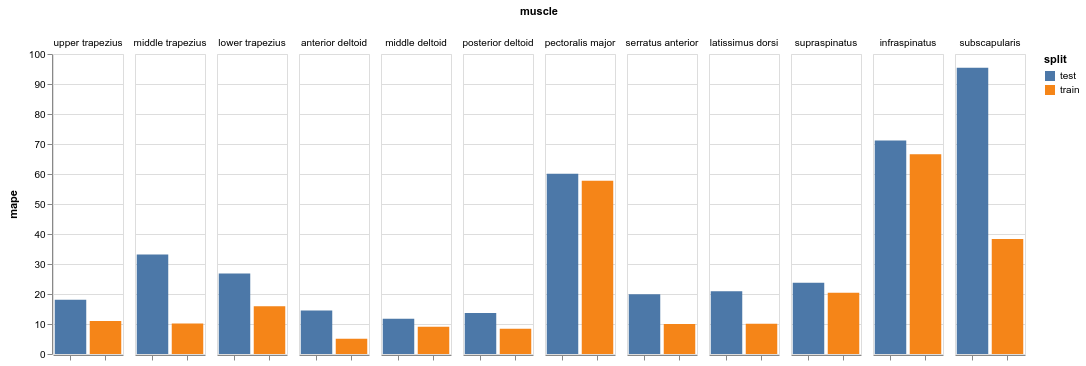

In [18]:
alt.Chart(r).mark_bar().encode(
    x=alt.X("split", axis=alt.Axis(title="", labels=False)),
    y="mape",
    color="split",
    column=alt.Column("muscle", sort=MUSCLES),
).properties(width=70)

# Part 4: Comparison with other studies

In [26]:
import dill as pickle

RECOMMANDATIONS_PATH = MODEL_PATH / "recommandations.pkl"
if RECOMMANDATIONS_PATH.is_file():
    with open(RECOMMANDATIONS_PATH, "rb") as h:
        recommandations = pickle.load(h)
else:
    recommandations = {}


## Boettcher et al., 2008

[Boettcher et al., 2008](https://onlinelibrary.wiley.com/doi/abs/10.1002/jor.20675) identified a unique combinations of 4 MVIC tests to normalize 12 shoulder muscles

In [27]:
if not RECOMMANDATIONS_PATH.is_file():
    recommandations["nt4"] = {
        0: ["11", "12", "13", "14"],
        1: ["11", "12", "13", "14"],
        2: ["11", "12", "13", "14"],
        3: ["11", "12", "13", "14"],
        4: ["11", "12", "13", "14"],
        5: ["11", "12", "13", "14"],
        6: ["11", "12", "13", "14"],
        7: ["11", "12", "13", "14"],
        8: ["11", "12", "13", "14"],
        9: ["11", "12", "13", "14"],
        10: ["11", "12", "13", "14"],
        11: ["11", "12", "13", "14"],
    }


## Dal Maso et al., 2016

[Dal Maso et al., 2016](https://www.sciencedirect.com/science/article/pii/S0003999316000307)

### As published

In [30]:
if not RECOMMANDATIONS_PATH.is_file():
    recommandations["dalmaso"] = {
        0: ["0", "2", "4", "11"],
        1: ["1", "2", "7", "9", "11", "14"],
        2: ["1", "2", "4", "10", "14"],
        3: ["3", "4", "8", "11"],
        4: ["2", "8", "11", "14"],
        5: ["1", "5"],
        6: ["7", "13"],
        7: ["2", "4", "6", "13", "14"],
        8: ["5", "6", "7", "10"],
        9: ["0", "2", "4", "11"],
        10: ["1", "2", "3", "14"],
        11: ["1", "2", "5", "9", "10", "14"],
    }


### Implemented on our data